In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('agg')

pd.set_option('max_columns', 999)
pd.set_option('max_rows', 250)

import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

seed = 60611

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

import time

In [13]:
class ArvatoData:
    
    def __init__(self, attributes_data_location=None, azdias_data_location=None, customer_data_location=None):
        self.attributes_data_location = attributes_data_location or 'data/DIAS Attributes - Values 2017.xlsx'
        self.azdias_data_location = azdias_data_location or 'data/arvato_data/Udacity_AZDIAS_052018.csv'
        self.customer_data_location = customer_data_location or 'data/arvato_data/Udacity_CUSTOMERS_052018.csv'
        
        self.data_prep_utils = {
            'one_hot_enc_no_del': ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ'],
            'one_hot_enc_del': ['ANREDE_KZ']
        }
        
        prepped_data = dict()
        
    def only_named_columns(self, col):
        """
        Removes columns from DataFrame while loaded that are unnamed
        """
        return 'Unnamed' not in col
            
    def load_data(self, ignore_clean_cache=False):

        # Attributes and Information
        print('loading attribute data from {}'.format(self.attributes_data_location))
        self.attributes = pd.read_excel(self.attributes_data_location, header=1, usecols=self.only_named_columns)
        self.attributes[['Attribute', 'Description']] = self.attributes[['Attribute', 'Description']].ffill()

#         information = pd.read_excel('data/DIAS Information Levels - Attributes 2017.xlsx', header=1, usecols=only_named_columns)

        print('loading azdias data from {}'.format(self.azdias_data_location))
        self.azdias = pd.read_csv(self.azdias_data_location, sep=';', usecols=self.only_named_columns)
        print('loading customers data from {}'.format(self.customer_data_location))
        self.customers = pd.read_csv(self.customer_data_location, sep=';', usecols=self.only_named_columns)
#         print('loading mailout test data')
#         self.mailout_test = pd.read_csv('data/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', usecols=only_named_columns)
#         print('loading mailout training data')
#         self.mailout_train = pd.read_csv('data/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', usecols=only_named_columns)
        print('Raw Data Loaded!')
    
    # Begin section of helper functions for data prep
    def lookup_unknown_val(self, col, attributes):
        try:
            mask = (self.attributes['Attribute'] == col) & (self.attributes['Meaning'].str.startswith('unknown'))
            unknown_val = self.attributes.loc[mask, 'Value']
            split_string = unknown_val.astype(str).str.cat(sep=',')
            
            return [int(x) for x in split_string.split(',')]
        except ValueError:
            return []
    
    def replace_unknowns_with_nan(self, df, attributes):
        for col in df.columns:
            df[col] = df[col].replace(self.lookup_unknown_val(col, attributes), np.nan)
        return df
    
    def missing_percentages(self, df):
        missing = pd.DataFrame(df.isna().sum() / df.shape[0]).reset_index()
        missing.columns = ['Attribute', 'Missing']
        return missing
    
    def remove_features_by_missingness(self, df, threshold=1):
        missing = self.missing_percentages(df)
        cols = missing.loc[missing['Missing'] > threshold, 'Attribute'].tolist()
        return cols
    
    def safe_drop_columns(self, df, cols):
        drop_cols = list(set(df.columns).intersection(set(cols)))
        return df.drop(drop_cols, axis=1)
    
    def clean_columns_18_19(self, df):
        columns = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
        df[columns] = df.loc[:, columns].replace(['X', 'XX'], np.nan)
        df[columns] = df.loc[:, columns].astype(float)
        return df
    
    def one_hot_encode(self, df, col, drop_first=False):
        dummies = pd.get_dummies(df[col], drop_first=drop_first)
        df_list = [df.drop(col, axis=1), dummies]
        return pd.concat(df_list, axis=1)
        
    def return_scaled_columns_list(self, df):
        scaled, not_scaled = df.select_dtypes(exclude='uint8').columns.tolist(), df.select_dtypes(include='uint8').columns.tolist()
        return scaled, not_scaled

    def create_scaler(self, df):
        scaled_col_list, non_scaled_col_list = self.return_scaled_columns_list(df)
        scaler = StandardScaler()
        scaler.fit(df[scaled_col_list])
        return scaler
    
    def scale_dataframe(self, df, scaler):
        scaled_col_list, non_scaled_col_list = self.return_scaled_columns_list(df)
        scaled_df = pd.DataFrame(scaler.transform(df[scaled_col_list]), columns=scaled_col_list)
        return pd.concat([scaled_df, df[non_scaled_col_list]], axis=1)

    def create_imputer(self, df):
        imputer = SimpleImputer(strategy='median')
        imputer.fit(df)
        return imputer
    
    def impute_values(self, df, imputer):
        return pd.DataFrame(imputer.transform(df), columns=df.columns)
    
    def fit_data_prep_tools(self, reload_azdias=False):
        
        # drop columns that we don't have an explanation for, byt keep the one object column
        drop_cols = list(set(self.azdias.columns) - set(self.attributes['Attribute'].unique()))
        drop_cols.remove('D19_LETZTER_KAUF_BRANCHE')
        self.data_prep_utils['drop_cols'] = drop_cols
        self.azdias = self.safe_drop_columns(self.azdias, self.data_prep_utils['drop_cols'])
        
        # lookup unknowns
        self.azdias = self.replace_unknowns_with_nan(self.azdias, self.attributes)
        
        # find features that are missing too much data, drop them
        self.data_prep_utils['missingness_cols'] = self.remove_features_by_missingness(self.azdias, 0.2)
        self.azdias = self.safe_drop_columns(self.azdias, self.data_prep_utils['missingness_cols'])
        
        # fix errors when loading
        self.azdias = self.clean_columns_18_19(self.azdias)
        
        # one hot encode
        self.azdias = self.one_hot_encode(self.azdias, self.data_prep_utils['one_hot_enc_del'], True)
        self.azdias = self.one_hot_encode(self.azdias, self.data_prep_utils['one_hot_enc_no_del'], False)
        
        # scale
        scaler = self.create_scaler(self.azdias)
        self.data_prep_utils['scaler'] = scaler

        self.azdias = self.scale_dataframe(self.azdias, scaler)
        
        # impute
        imputer = self.create_imputer(self.azdias)
        self.data_prep_utils['imputer'] = imputer

        self.azdias = self.impute_values(self.azdias, imputer)
        
        if reload_azdias:
            print('loading azdias data from {}'.format(self.azdias_data_location))
            self.azdias = pd.read_csv(self.azdias_data_location, sep=';', usecols=self.only_named_columns)
            print('Finished reloading azdias!')
        
    def prep_dataframe(self, data_name, csv_location):
        pass
        
    

In [14]:
a = ArvatoData()

In [15]:
a.load_data()

loading attribute data from data/DIAS Attributes - Values 2017.xlsx
loading azdias data from data/arvato_data/Udacity_AZDIAS_052018.csv
loading customers data from data/arvato_data/Udacity_CUSTOMERS_052018.csv
Raw Data Loaded!


In [16]:
a.fit_data_prep_tools()

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [2]:
def only_named_columns(col):
    """
    Removes columns from DataFrame while loaded that are unnamed
    """
    return 'Unnamed' not in col

In [3]:
attributes = pd.read_excel('data/DIAS Attributes - Values 2017.xlsx', header=1, usecols=only_named_columns)
attributes[['Attribute', 'Description']] = attributes[['Attribute', 'Description']].ffill()

In [4]:
mailout_test = pd.read_csv('data/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

mailout_train = pd.read_csv('data/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/home/patrick/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [24]:
def load_data(ignore_clean_cache=False):
    """
    Loads data from either source csv or from cleaned cache. Six (6) files
    are expected
        * data/arvato_data/Udacity_AZDIAS_052018.csv
        * data/arvato_data/Udacity_CUSTOMERS_052018.csv
        * data/arvato_data/Udacity_MAILOUT_052018_TEST.csv
        * data/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv
        
        * data/DIAS Attributes - Values 2017.xlsx
        * data/DIAS Information Levels - Attributes 2017.xlsx
        
    Arguments:
        ignore_clean_cache: reloads raw data, even if clean cache exists
    
    Returns:
        azdias, customer, mailout_test, mailout_train, attributes, information
    """
    def only_named_columns(col):
        """
        Removes columns from DataFrame while loaded that are unnamed
        """
        return 'Unnamed' not in col
    
    # Attributes and Information
    
    attributes = pd.read_excel('data/DIAS Attributes - Values 2017.xlsx', header=1, usecols=only_named_columns)
    attributes[['Attribute', 'Description']] = attributes[['Attribute', 'Description']].ffill()
    
    information = pd.read_excel('data/DIAS Information Levels - Attributes 2017.xlsx', header=1, usecols=only_named_columns)
    
    print('loading azdias data...')
    azdias = pd.read_csv('data/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', usecols=only_named_columns)
    print('loading customers data...')
    customers = pd.read_csv('data/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', usecols=only_named_columns)
    print('loading mailout test data')
    mailout_test = pd.read_csv('data/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', usecols=only_named_columns)
    print('loading mailout training data')
    mailout_train = pd.read_csv('data/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', usecols=only_named_columns)
    
    print('Returning data in this order: azdias, customers, mailout_test, mailout_train, attributes, information')

    return azdias, customers, mailout_test, mailout_train, attributes, information

# cleaning the dataframe pipeline
def clean_dataframe(df, attributes, drop_cols, missingness_cols):
    def clean_columns_18_19(df):
        columns = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
        df[columns] = df.loc[:, columns].replace(['X', 'XX'], np.nan)
        df[columns] = df.loc[:, columns].astype(float)
        return df
    def ost_west_encoder(df):
        encoder = {
            'O': 0,
            'W': 1
        }
        df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map(encoder)
        return df
    def male_encoder(df):
        encoder = {
            2: 0,
            1: 1
        }
        df['ANREDE_KZ'] = df['ANREDE_KZ'].map(encoder)
        return df
    def one_hot_encode(df, col, drop_first=False):
        dummies = pd.get_dummies(df[col], drop_first=drop_first)
        df_list = [df.drop(col, axis=1), dummies]
        return pd.concat(df_list, axis=1)
    def lookup_unknown_val(col, attributes):
        try:
            mask = (attributes['Attribute'] == col) & (attributes['Meaning'].str.startswith('unknown'))
            unknown_val = attributes.loc[mask, 'Value']
            split_string = unknown_val.astype(str).str.cat(sep=',')
            
            return [int(x) for x in split_string.split(',')]
        except ValueError:
            return []
    def replace_unknowns_with_nan(df, attributes):
        for col in df.columns:
            df[col] = df[col].replace(lookup_unknown_val(col, attributes), np.nan)
        return df
    def drop_columns(df, cols):
        drop_cols = list(set(df.columns).intersection(set(cols)))
        return df.drop(drop_cols, axis=1)

    
    df = clean_columns_18_19(df)
    df = one_hot_encode(df, ['ANREDE_KZ'], True)
    df = one_hot_encode(df, ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ'], False)
    df = replace_unknowns_with_nan(df, attributes)
    df = drop_columns(df, drop_cols) # missing columns in descriptions
    df = drop_columns(df, missingness_cols) # columns with high missing values
    
    return df

# Calculating columns to drop because of missing data
def missing_percentages(df):
    missing = pd.DataFrame(df.isna().sum() / df.shape[0]).reset_index()
    missing.columns = ['Attribute', 'Missing']
    return missing
def remove_features_by_missingness(df, threshold=1):
    missing = missing_percentages(df)
    cols = missing.loc[missing['Missing'] > threshold, 'Attribute'].tolist()
    return cols

# creating scalers, and scaling dataframes
def return_scaled_columns_list(df):
    scaled, not_scaled = df.select_dtypes(exclude='uint8').columns.tolist(), df.select_dtypes(include='uint8').columns.tolist()

    return scaled, not_scaled

def create_scaler(df):
    scaled_col_list, non_scaled_col_list = return_scaled_columns_list(df)
    
    scaler = StandardScaler()
    scaler.fit(df[scaled_col_list])
    
    return scaler
def scale_dataframe(df, scaler):
    scaled_col_list, non_scaled_col_list = return_scaled_columns_list(df)
    scaled_df = pd.DataFrame(scaler.transform(df[scaled_col_list]), columns=scaled_col_list)
    
    return pd.concat([scaled_df, df[non_scaled_col_list]], axis=1)

# createing imputers, and imputing values
def create_imputer(df):
    imputer = SimpleImputer(strategy='median')
    imputer.fit(df)
    return imputer
def impute_values(df, imputer):
    return pd.DataFrame(imputer.transform(df), columns=df.columns)

In [6]:
# columns that are to be dropped because of a lack of information in the documentation
drop_cols = ['KBA13_ANTG2',
             'D19_SCHUHE',
             'D19_REISEN',
             'D19_VERSI_ONLINE_DATUM',
             'ALTER_KIND3',
             'KBA13_ANTG1',
             'D19_BANKEN_REST',
             'STRUKTURTYP',
             'CJT_TYP_5',
             'D19_TELKO_REST',
             'D19_SONSTIGE',
             'EINGEZOGENAM_HH_JAHR',
             'D19_BEKLEIDUNG_REST',
             'D19_ENERGIE',
             'GEMEINDETYP',
             'D19_KOSMETIK',
             'D19_WEIN_FEINKOST',
             'ALTER_KIND4',
             'KBA13_HHZ',
             'LNR',
             'D19_SAMMELARTIKEL',
             'D19_BANKEN_DIREKT',
             'ANZ_KINDER',
             'D19_LOTTO',
             'DSL_FLAG',
             'UNGLEICHENN_FLAG',
             'D19_VERSI_DATUM',
             'D19_RATGEBER',
             'D19_GARTEN',
             'D19_BUCH_CD',
             'RT_SCHNAEPPCHEN',
             'RT_UEBERGROESSE',
             'D19_BEKLEIDUNG_GEH',
             'KBA13_BAUMAX',
             'D19_BANKEN_LOKAL',
             'ALTER_KIND1',
             'D19_VERSI_ONLINE_QUOTE_12',
             'VHN',
             'D19_LEBENSMITTEL',
             'VK_ZG11',
             'D19_HANDWERK',
             'VERDICHTUNGSRAUM',
             'KOMBIALTER',
             'KONSUMZELLE',
             'D19_VOLLSORTIMENT',
             'CJT_TYP_4',
             'D19_TIERARTIKEL',
             'D19_VERSAND_REST',
             'D19_BIO_OEKO',
             'MOBI_RASTER',
             'UMFELD_ALT',
             'KBA13_ANTG4',
             'CJT_KATALOGNUTZER',
             'D19_NAHRUNGSERGAENZUNG',
             'CJT_TYP_2',
             'KBA13_KMH_210',
             'SOHO_KZ',
             'EINGEFUEGT_AM',
             'D19_TELKO_ONLINE_QUOTE_12',
             'CJT_TYP_3',
             'CJT_TYP_1',
             'ARBEIT',
             'D19_BANKEN_GROSS',
             'AKT_DAT_KL',
             'KBA13_GBZ',
             'VK_DISTANZ',
             'UMFELD_JUNG',
             'ANZ_STATISTISCHE_HAUSHALTE',
             'FIRMENDICHTE',
             'CJT_TYP_6',
             'D19_DROGERIEARTIKEL',
             'ALTER_KIND2',
             'D19_BILDUNG',
             'D19_DIGIT_SERV',
             'D19_KINDERARTIKEL',
             'HH_DELTA_FLAG',
             'EXTSEL992',
             'D19_TECHNIK',
             'RT_KEIN_ANREIZ',
             'D19_SOZIALES',
             'D19_TELKO_MOBILE',
             'KBA13_CCM_1401_2500',
             'ALTERSKATEGORIE_FEIN',
             'D19_FREIZEIT',
             'VK_DHT4A',
             'KBA13_ANTG3',
             'D19_KONSUMTYP_MAX',
             'VHA',
             'D19_VERSI_OFFLINE_DATUM',
             'D19_VERSICHERUNGEN',
             'KK_KUNDENTYP',
             'CAMEO_INTL_2015',
             'D19_HAUS_DEKO']

In [25]:
azdias, customers, mailout_test, mailout_train, attributes, information = load_data()

loading azdias data...


/home/patrick/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


loading customers data...
loading mailout test data
loading mailout training data
Returning data in this order: azdias, customers, mailout_test, mailout_train, attributes, information


In [38]:
drop_cols = list(set(azdias.columns) - set(attributes['Attribute'].unique()))
drop_cols.remove('D19_LETZTER_KAUF_BRANCHE')

In [50]:

        
def prep_azdias(azdias, attributes):
    
    return_object = {}
    
    
    
    return_object['drop_cols'] = drop_cols
    azdias.drop(drop_cols, axis=1)
    
    
    azdias = replace_unknowns_with_nan(azdias, attributes)
    
    missingness_cols = remove_features_by_missingness(azdias, 0.2)
    return_object['missingness_cols'] = missingness_cols
    azdias = drop_columns(azdias, missingness_cols)
    azdias = clean_columns_18_19(azdias)
    
    def one_hot_encode(df, col, drop_first=False):
        dummies = pd.get_dummies(df[col], drop_first=drop_first)
        df_list = [df.drop(col, axis=1), dummies]
        
    azdias = one_hot_encode(azdias, ['ANREDE_KZ'], True)
    azdias = one_hot_encode(azdias, ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ'], False)

    def return_scaled_columns_list(df):
        scaled, not_scaled = df.select_dtypes(exclude='uint8').columns.tolist(), df.select_dtypes(include='uint8').columns.tolist()

        return scaled, not_scaled

    def create_scaler(df):
        scaled_col_list, non_scaled_col_list = return_scaled_columns_list(df)

        scaler = StandardScaler()
        scaler.fit(df[scaled_col_list])

        return scaler
    def scale_dataframe(df, scaler):
        scaled_col_list, non_scaled_col_list = return_scaled_columns_list(df)
        scaled_df = pd.DataFrame(scaler.transform(df[scaled_col_list]), columns=scaled_col_list)

        return pd.concat([scaled_df, df[non_scaled_col_list]], axis=1)

    # createing imputers, and imputing values
    def create_imputer(df):
        imputer = SimpleImputer(strategy='median')
        imputer.fit(df)
        return imputer
    def impute_values(df, imputer):
        return pd.DataFrame(imputer.transform(df), columns=df.columns)
    
    scaler = create_scaler(azdias)
    return_object['scaler'] = scaler
    
    azdias = scale_dataframe(azdias, scaler)
    
    imputer = create_imputer(azdias)
    return_object['inputer'] = imputer
    
    azdias = impute_values(azdias, imputer)
    
    return azdias, return_object


In [63]:
arv = ArvatoData()

In [64]:
arv.load_data()

loading attribute data from data/DIAS Attributes - Values 2017.xlsx
loading azdias data from data/arvato_data/Udacity_AZDIAS_052018.csv


/home/patrick/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


loading customers data from data/arvato_data/Udacity_CUSTOMERS_052018.csv
Raw Data Loaded!


In [51]:
azdias_prepped, return_object = prep_azdias(azdias, attributes)

TypeError: 'NoneType' object is not subscriptable

In [39]:
def pipeline(azdias, attributes, df):
    
    drop_cols = list(set(azdias.columns) - set(attributes['Attribute'].unique()))
    drop_cols.remove('D19_LETZTER_KAUF_BRANCHE')
    
    df.drop(drop_cols, axis=1)
        
    def lookup_unknown_val(col, attributes):
        try:
            mask = (attributes['Attribute'] == col) & (attributes['Meaning'].str.startswith('unknown'))
            unknown_val = attributes.loc[mask, 'Value']
            split_string = unknown_val.astype(str).str.cat(sep=',')
            
            return [int(x) for x in split_string.split(',')]
        except ValueError:
            return []
    def replace_unknowns_with_nan(df, attributes):
        for col in df.columns:
            df[col] = df[col].replace(lookup_unknown_val(col, attributes), np.nan)
        return df
    
    azdias = replace_unknowns_with_nan(azdias, attributes)
    df = replace_unknowns_with_nan(df, attributes)
    
    def lookup_unknown_val(col, attributes):
        try:
            mask = (attributes['Attribute'] == col) & (attributes['Meaning'].str.startswith('unknown'))
            unknown_val = attributes.loc[mask, 'Value']
            split_string = unknown_val.astype(str).str.cat(sep=',')
            
            return [int(x) for x in split_string.split(',')]
        except ValueError:
            return []
    def replace_unknowns_with_nan(df, attributes):
        for col in df.columns:
            df[col] = df[col].replace(lookup_unknown_val(col, attributes), np.nan)
        return df

In [40]:
sorted(drop_cols)

['AKT_DAT_KL',
 'ALTERSKATEGORIE_FEIN',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ARBEIT',
 'CAMEO_INTL_2015',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KONSUMTYP_MAX',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE',
 'D19_SOZIALES',
 'D19_TECHNIK',
 'D19_TELKO_MOBILE',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_TELKO_REST',
 'D19_TIERARTIKEL',
 'D19_VERSAND_REST',
 'D19_VERSICHERUNGEN',
 'D19_VERSI_DATUM',
 'D19_VERSI

In [35]:
features

['AGER_TYP',
 'ALTERSKATEGORIE_GROB',
 'ALTER_HH',
 'ANREDE_KZ',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'BALLRAUM',
 'BIP_FLAG',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CAMEO_DEUINTL_2015',
 'CJT_GESAMTTYP',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT_RZ',
 'D19_BANKEN_GROSS_RZ',
 'D19_BANKEN_LOKAL_RZ',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_REST_RZ',
 'D19_BEKLEIDUNG_GEH_RZ',
 'D19_BEKLEIDUNG_REST_RZ',
 'D19_BILDUNG_RZ',
 'D19_BIO_OEKO_RZ',
 'D19_BUCH_RZ',
 'D19_DIGIT_SERV_RZ',
 'D19_DROGERIEARTIKEL_RZ',
 'D19_ENERGIE_RZ',
 'D19_FREIZEIT_RZ',
 'D19_GARTEN_RZ',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_HANDWERK_RZ',
 'D19_HAUS_DEKO_RZ',
 'D19_KINDERARTIKEL_RZ',
 'D19_KONSUMTYP',
 'D19_KK_KUNDENTYP',
 'D19_KOSMETIK_RZ',
 'D19_LEBENSMITT

In [10]:
y = mailout_train[['RESPONSE']]
X = mailout_train.drop('RESPONSE', axis=1)

In [8]:
# def supervised_ml_pipeline(df, azdias_cleaned, attributes, drop_cols):
#     missingness_cols = remove_features_by_missingness(primary_df, 0.2)
#     primary_cleaned = clean_dataframe(primary_df, attributes, drop_cols, missingness_cols)
#     secondary_cleaned = clean_dataframe(secondary_df, attributes, drop_cols, missingness_cols)
#     scaler = create_scaler(primary_cleaned)
#     primary_scaled = scale_dataframe(primary_cleaned, scaler)
#     secondary_scaled = scale_dataframe(secondary_cleaned, scaler)
#     imputer = create_imputer(primary_scaled)
#     primary_final = impute_values(primary_scaled, imputer)
#     secondary_final = impute_values(secondary_scaled, imputer)
    
#     return primary_final, secondary_final

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y)

In [20]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.33, stratify=y_test)

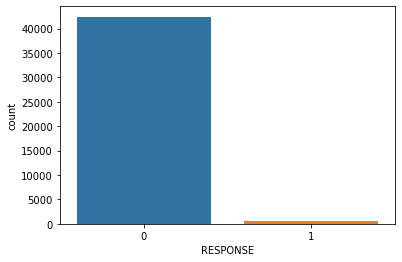

In [19]:
sns.countplot(data=mailout_train, x='RESPONSE')

Probably will use AUC to start, that's a good metric for classification

In [23]:

X_train_clean

['ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'HH_DELTA_FLAG',
 'KBA05_ALTER1',
 'KBA05_ALTER2',
 'KBA05_ALTER3',
 'KBA05_ALTER4',
 'KBA05_ANHANG',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_AUTOQUOT',
 'KBA05_BAUMAX',
 'KBA05_CCM1',
 'KBA05_CCM2',
 'KBA05_CCM3',
 'KBA05_CCM4',
 'KBA05_DIESEL',
 'KBA05_FRAU',
 'KBA05_GBZ',
 'KBA05_HERST1',
 'KBA05_HERST2',
 'KBA05_HERST3',
 'KBA05_HERST4',
 'KBA05_HERST5',
 'KBA05_KRSAQUOT',
 'KBA05_KRSHERST1',
 'KBA05_KRSHERST2',
 'KBA05_KRSHERST3',
 'KBA05_KRSKLEIN',
 'KBA05_KRSOBER',
 'KBA05_KRSVAN',
 'KBA05_KRSZUL',
 'KBA05_KW1',
 'KBA05_KW2',
 'KBA05_KW3',
 'KBA05_MAXAH',
 'KBA05_MAXBJ',
 'KBA05_MAXHERST',
 'KBA05_MAXSEG',
 'KBA05_MAXVORB',
 'KBA05_MOD1',
 'KBA05_MOD2',
 'KBA05_MOD3',
 'KBA05_MOD4',
 'KBA05_MOD8',
 'KBA05_MOTOR',
 'KBA05_MOTRAD',
 'KBA05_SEG1',
 'KBA05_SEG10',
 'KBA05_SEG2',
 'KBA05_SEG3',
 'KBA05_SEG4',
 'KBA05_SEG5',
 'KBA05_SEG6',
 'KBA05_SEG7',
 'KBA05_SEG8',
 'KBA0